In [1]:
import numpy as np
import scipy

In [2]:
data  = np.random.rand(6,6)*1000 # some random data

In [3]:
P = np.array([
             [.2, .3, .5],
             [.3, .4, .3],
             [.5, .3, .2]
             ])

## 1 Building the Diffusion Map

### 1.1 Gaussian Kernel Function
The Gaussian Kernel Function will define the non-normalized connectivity between two points. Note that alpha controls the size of the 'connectivity neighborhood.' The larger the alpha, the larger the neighborhood. 

The function is given by:

<center>
$
\begin{align}
\textrm{connectivity}(x,y) \propto K(x, y) &= exp({-\frac{|| x - y ||^2}{\alpha}}) \\ \\
\end{align}
$
</center>

In [4]:
def RBF(x, y, alpha=1):
    """ Gaussian kernel function for two vectors x and y. With neighborhood distance alpha.
    
    Arguments:
        - x : First vector
        - y : Second vector
        - alpha: neighborhood factor. *Note bigger alpha increases RBF value --> bigger neighborhood
    
    return: Real num in [0, 1]
    """
    return np.exp(-(np.linalg.norm(np.array(x) - np.array(y))**2) / alpha)

In [5]:
# calculation check
assert((RBF([0,0], [1,1], 1) - np.exp(-2)) < 0.0001)
assert((RBF([0,0], [0,0], 1) - 1 < 0.0001))

### 1.2 Data Kernelizer

In [6]:
def kernelize(data, alpha=1):
    """ Given some data convert it to a kernel matrix using some given kernel.
    
    Arguments:
        data : Data matrix (N, C)
        k: Kernel function
        alpha: neighborhood factor. *Note bigger alpha increases kernel function value.
    """
    # TODO could make n^2/2
    
    kernel_matrix = []
    for d_i in data:
        row = [RBF(d_i, d_j, alpha) for d_j in data]
        kernel_matrix.append(row)
    return np.array(kernel_matrix)

### 1.3 Diffusion Distance
Diffusion distance measures the similarity of two points in the observation space as the connectivity (probability of “jumping”) between them.

Given by:

<center>
$
\begin{align}
D_t(X_i, X_j)^2 &= \sum_{u\in{}X}\mid{}p_t(X_i, u) - p_t(X_j, u)\mid{}^2 \\ \\
                &= \sum_{u\in{}X}\mid{}p_{ik}^t - p_{kj}^t\mid{}^2
\end{align}
$
</center>

In [7]:
# Note theres no square in the diffusion distance
def diffusion_dist(i, j):
    """ Computes the diffusion distance between two vectors X_i and X_j.
    
    Arguments:
        i: first vector
        j: second vector
    """
    return np.linalg.norm(i - j)**2

In [8]:
P_1 = np.array([.2, .3, .5])
P_2 = np.array([.5, .3, .2])
assert(np.abs(diffusion_dist(P_1,P_2) == (.3**2 + .0**2 + .3**2)))
print(diffusion_dist(P_1, P_2) )

0.18


### 1.4 Diffusion Matrix/Map Generator
A $t=1$ and $m=r$, diffusion matrix $M$ is (N, N) where the data is (N, R). Here $M_{ij}$ will approximate the diffusion distance between points $i$ and $j$ at step t.

For $m<1$ the diffusion matrix $M$ is $(N, m)$, where m is the reduced data size.

In [9]:
def diffusion_map_RBF(data, m, t=1, alpha=1):
    """ Comptues the diffusion matrix for a given data set using the RBF kernel function. 
    Reduces the dimensionality of each data point to size m.
    
    Arguments:
        data: (N, C) matrix of data points. Each point is a row vector.
        m: New reeduced dimension size of matrix. m <= C.
        alpha: Neighborhood size for RBF kernel
    """
    N, C = data.shape
    # Valid dimensionality reduction request
    if (m < 1) or (m > C):
        raise Exception('Bad reduced dimension. Make sure m is with [1, rank(data)] %d > %d' % (m, C))
        
    # FIXME Belongs with below FIXME Adjust new dimension for indexing get first m-1 eigen values
    # m = m - 1
    
    diffusion_matrix = []
    
    # 1. Define a kernel K    
    kernel_matrix = kernelize(data, alpha)
    
    # 2. Create diffusion matrix (P - the row normalized kernel)
    P = kernel_matrix / np.sum(kernel_matrix, axis=1).reshape(-1, 1)
    P = np.linalg.matrix_power(P, t)
        
    # 3. Calculate the eigenvectors of the diffusion matrix.
    eigen_vals, eigen_vecs = np.linalg.eig(P)    
    
    idx = np.argsort(eigen_vals)[::-1]
    eigen_vecs = eigen_vecs[:, idx]
    eigen_vals = eigen_vals[idx]

    # 4. Map to the d-dimensional diffusion space at time t, 
    #    using the d dominant eigenvectors and -values as
    for i in range(len(data)):
        row = (eigen_vals[i] * eigen_vecs[i , :])
        # Reduce the diffusion matrix to dimension m
        diffusion_matrix.append(row[:m])
        
    return np.array(diffusion_matrix)

In [10]:
# Note we use SVD instead of linalg.eig due to numerical stability
#u,d,v = np.linalg.svd(P)
#eigen_vals = d**2 # Sigma values are sqrt(eigen values)
#eigen_vecs = v.T  # columns of v.T are the eigen vectors... 

#eigen_vals = eigen_vals**t

# Sort the eigen vectors by the eigen value
#idx = np.argsort(eigen_vals)[::-1]
#eigen_vecs = eigen_vecs[:, idx]
#eigen_vals = eigen_vals[idx]

## 2 Visualizing PCA, LDA and DM

### 2.1 Iris Dataset

In [11]:
print(__doc__)

import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

iris = datasets.load_iris()

X = iris.data
y = iris.target

target_names = iris.target_names

Automatically created module for IPython interactive environment


explained variance ratio (first two components): [ 0.92461621  0.05301557]


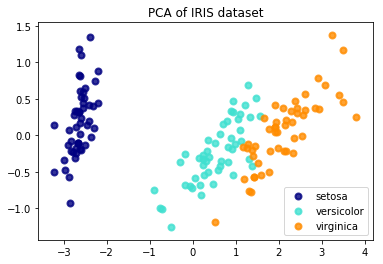

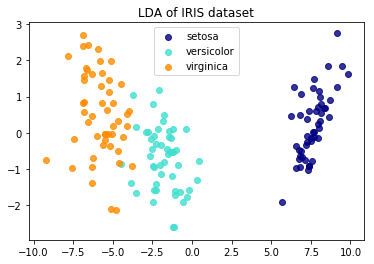

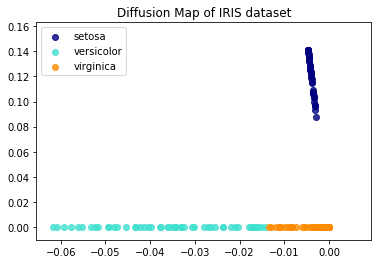

In [12]:
%matplotlib inline 

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X, y).transform(X)

X_r3 = diffusion_map_RBF(X, 2, t=2, alpha=.05)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
colors = ['navy', 'turquoise', 'darkorange']
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of IRIS dataset')

plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], alpha=.8, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of IRIS dataset')


plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r3[y == i, 0], X_r3[y == i, 1], alpha=.8, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('Diffusion Map of IRIS dataset')

plt.show()

### 2.3 Visualizing DM w/ Iris on its own

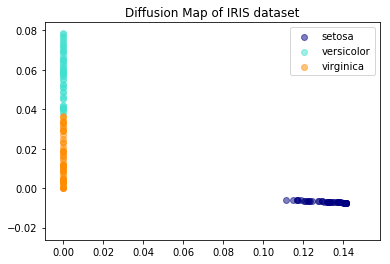

In [13]:
X_r3 = diffusion_map_RBF(X, m=2, t=1, alpha=.05)

colors = ['navy', 'turquoise', 'darkorange']
plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r3[y == i, 0], X_r3[y == i, 1], alpha=.5, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('Diffusion Map of IRIS dataset')

plt.show()

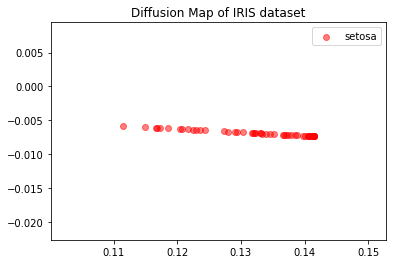

In [14]:
colors = ['red']
plt.figure()
for color, i, target_name in zip(colors, [0], target_names):
    plt.scatter(X_r3[y == i, 0], X_r3[y == i, 1], alpha=.5, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('Diffusion Map of IRIS dataset')

plt.show()

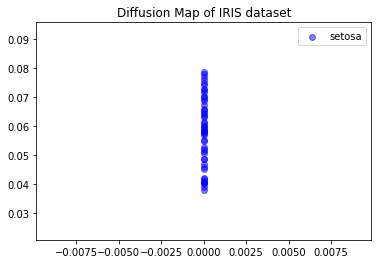

In [15]:
colors = ['blue']
plt.figure()
for color, i, target_name in zip(colors, [1], target_names):
    plt.scatter(X_r3[y == i, 0], X_r3[y == i, 1], alpha=.5, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('Diffusion Map of IRIS dataset')

plt.show()

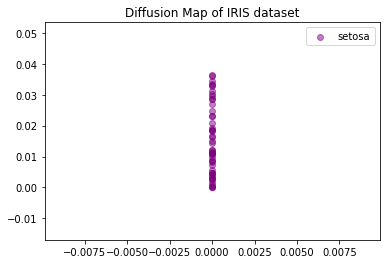

In [16]:
colors = ['purple']
plt.figure()
for color, i, target_name in zip(colors, [2], target_names):
    plt.scatter(X_r3[y == i, 0], X_r3[y == i, 1], alpha=.5, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('Diffusion Map of IRIS dataset')

plt.show()

## 3 Testing acc of same classifier on each

In [17]:
from sklearn import svm
clf = svm.SVC(gamma=0.001, C=100., kernel='linear')

### 3. 1 PCA Acc

In [18]:
clf.fit(X_r, y)
sum(clf.predict(X_r) == y)/len(y)

0.97333333333333338

### 3.2 LDA Acc

In [19]:
clf.fit(X_r2, y)
sum(clf.predict(X_r2) == y)/len(y)

0.97999999999999998

### 3.3 Diffusion Map Acc

In [20]:
clf.fit(X_r3, y)
sum(clf.predict(X_r3) == y)/len(y)

1.0